# Diffuse emission and source populations


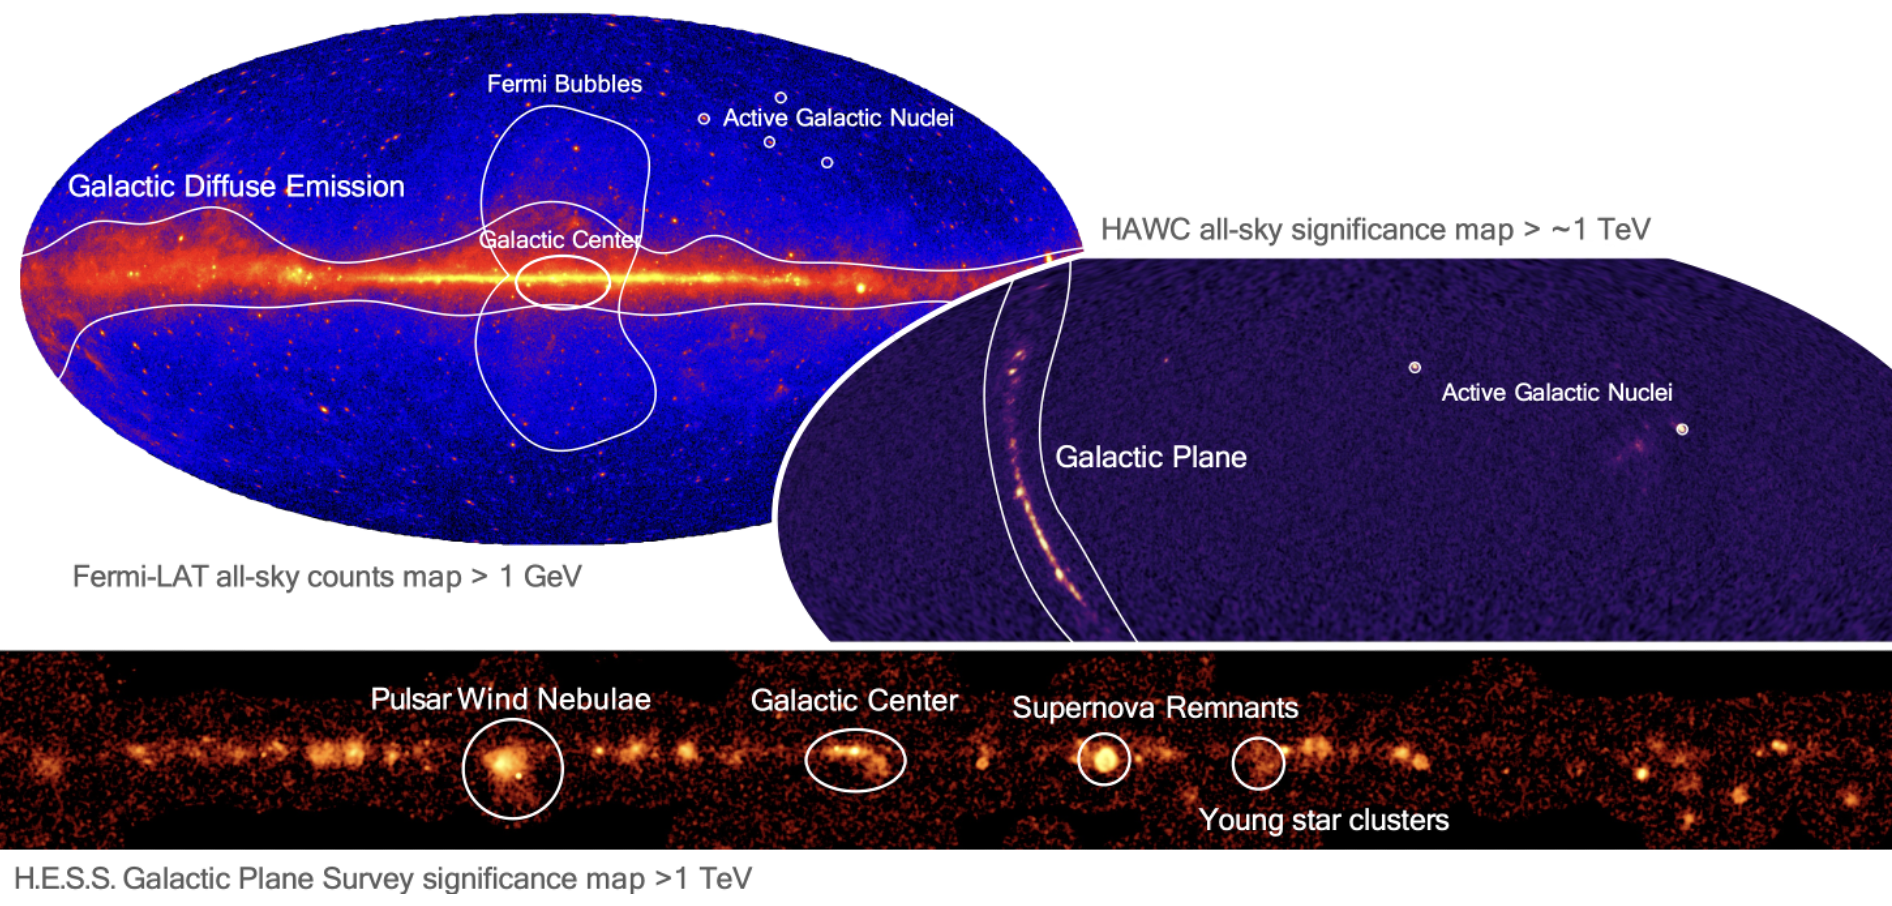

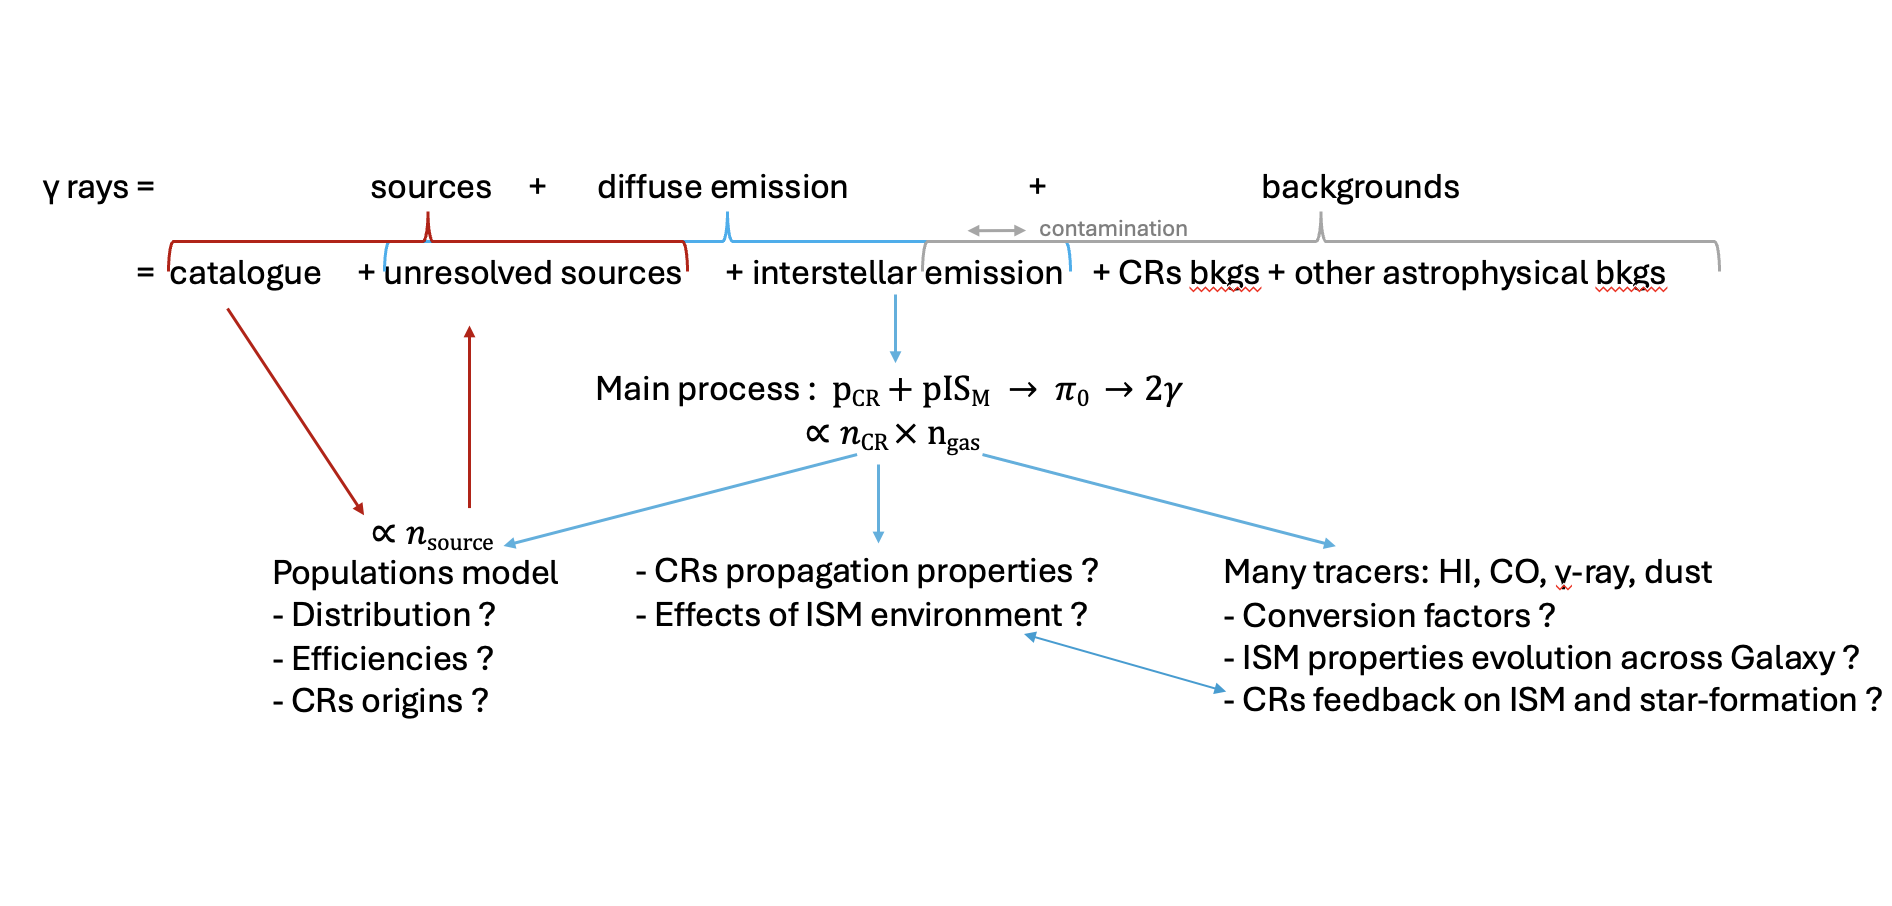

In [1]:
#imports und utilities
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

from gammapy.modeling.models import Models
from gammapy.modeling.models import SkyModel, ConstantSpatialModel, PowerLawSpectralModel, PowerLawNormSpectralModel, TemplateSpatialModel
from gammapy.modeling.models import  SmoothBrokenPowerLawSpectralModel, BrokenPowerLawSpectralModel
from gammapy.maps import Map
from gammapy.maps import MapAxis, WcsGeom
from gammapy.datasets import MapDataset


defcol=[u'#1f77b4',
 u'#ff7f0e',
 u'#2ca02c',
 u'#d62728',
 u'#9467bd',
 u'#8c564b',
 u'#e377c2',
 u'#7f7f7f',
 u'#bcbd22',
 u'#17becf',
 'k']


## Source models

Source models used for this simulations are the same as the ones used for the CTA-GPS simulation (https://arxiv.org/abs/2310.02828)

Available here: https://zenodo.org/records/10008527

In [2]:
path = os.getcwd()

path = "/Users/qremy/Work/Data/SWGO/" # CHANGE THIS
cta_gps_models = Models.read(path+"cta_gps/models/models_gps.yaml")


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Parameter 'lon_0' not defined in YAML file. Using default value: nan deg
Parameter 'lat_0' not defined in YAML file. Using default value: nan deg
Parameter 'lon_0' not defined in YAML file. Using default value: nan deg
Parameter 'lat_0' not defined in YAML file. Using default value: nan deg
Invalid value BUNIT='JY/BEAM' in FITS header. Setting empty unit.
Parameter 'lon_0' not defined in YAML file. Using default value: nan deg
Parameter 'lat_0' not defined in YAML file. Using default value: nan deg
Invalid value BUNIT='JY/BEAM' in FITS header. Setting empty unit.
Parameter 'lon_0' not defined in YAML file. Using default value: nan deg
Parameter 'lat_0' not defined in YAML file. Using default value: nan deg
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent'. [astropy.wcs.wcs]
Parameter 'lon_0' not defined in YAML file. Using default value:

In [3]:
print("Number of models:", len(cta_gps_models))

Number of models: 1650


## Diffuse emission



### Diffuse emission models from Fermi-LAT

Available here : https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html

v5 (used for 3GHL catalogue): https://arxiv.org/abs/1602.07246

v7 (used for 4FGL catalogue): https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/4fgl/Galactic_Diffuse_Emission_Model_for_the_4FGL_Catalog_Analysis.pdf

In [4]:

iem_fermi_v5 = SkyModel(spatial_model=TemplateSpatialModel.read(path+"models/iem/gll_iem_v05_rev1.fit", normalize=False),
                      spectral_model=PowerLawNormSpectralModel()
         )

iem_fermi_v7 = SkyModel(spatial_model=TemplateSpatialModel.read(path+"models/iem/gll_iem_v07.fits", normalize=False),
                      spectral_model=PowerLawNormSpectralModel()
         )

In [5]:
iem_fermi_v5.spatial_model.map.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [6]:
iem_fermi_v7.spatial_model.map.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [7]:
#diff = iem_fermi_v5.spatial_model.map - iem_fermi_v7.evaluate_geom(iem_fermi_v5.spatial_model.map.geom)
#diff.plot_interactive()

### Interstellar emission models (IEM)

Interstellar emission models describe the pi0 and IC components of the diffuse emission.

The templates are build with hermes code (https://github.com/cosmicrays/hermes). Other code like GALPROP can be used to produce these kind of templates.

The base and varmin-rescaled models are described in https://arxiv.org/pdf/2310.02828.pdf (and reference therein) available at https://zenodo.org/records/10008527. The CRINGE model is described in https://arxiv.org/abs/2211.15607 available at https://zenodo.org/records/7859442.

In [8]:
def create_iem_model(filename, name):

    template_iem = TemplateSpatialModel.read(
        filename=filename, normalize=False
    )
    
    return SkyModel(
        spectral_model=PowerLawNormSpectralModel(),
        spatial_model=template_iem,
        name=name,
    )

iem_base = create_iem_model(path+"models/iem/IEM_base.fits", name="IEM_base")
iem_varmin = create_iem_model(path+"models/iem/IEM_varmin.fits", name="IEM_varmin")
iem_varmin_rescaled = create_iem_model(path+"models/iem/IEM_varmin_rescaled.fits", name="IEM_varmin_rescaled")


try:
    iem_cringe = create_iem_model(path+"models/iem/IEM_CRINGE_fiducial_total.fits.gz", name="IEM_CRINGE_fiducial_total")
except:
    # for CRINGE the models is splitted into the different components 
    iem_cringe_ic = Map.read("Photon_AAfrag_Galprop_Ferr_Fiducial_256_IC_gammapy.fits") #Inverse Compton
    iem_cringe_pi0_hi = Map.read("Photon_AAfrag_Galprop_Ferr_Fiducial_256_HI_gammapy.fits") #Atomic gas
    iem_cringe_pi0_h2 = Map.read("Photon_AAfrag_Galprop_Ferr_Fiducial_256_H2_gammapy.fits") #Molecular gas
    iem_cringe_template = iem_cringe_ic + iem_cringe_pi0_hi + iem_cringe_pi0_h2
    iem_cringe_template.write(path+"models/iem/IEM_CRINGE_fiducial_total.fits.gz")
    iem_cringe = create_iem_model(path+"models/iem/IEM_CRINGE_fiducial_total.fits.gz")


In [9]:
iem_base.spatial_model.map.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [10]:
iem_varmin.spatial_model.map.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [11]:
iem_varmin_rescaled.spatial_model.map.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

In [12]:
iem_cringe.spatial_model.map.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

### IEM and diffuse emission comparison

First we define and energy axis and a geomtry to define the region to look up

In [13]:
energy_axis =  MapAxis.from_energy_bounds(1e-3, 1000, 10, unit=u.TeV, per_decade=True, name="energy_true", node_type="edges")
energies = energy_axis.center.to("TeV")

fig_geom = WcsGeom.create(
                skydir=(0,0),
                binsz=0.1,
                width=(30, 10),
                frame="galactic",
                proj="CAR",
                axes=[energy_axis],
                )

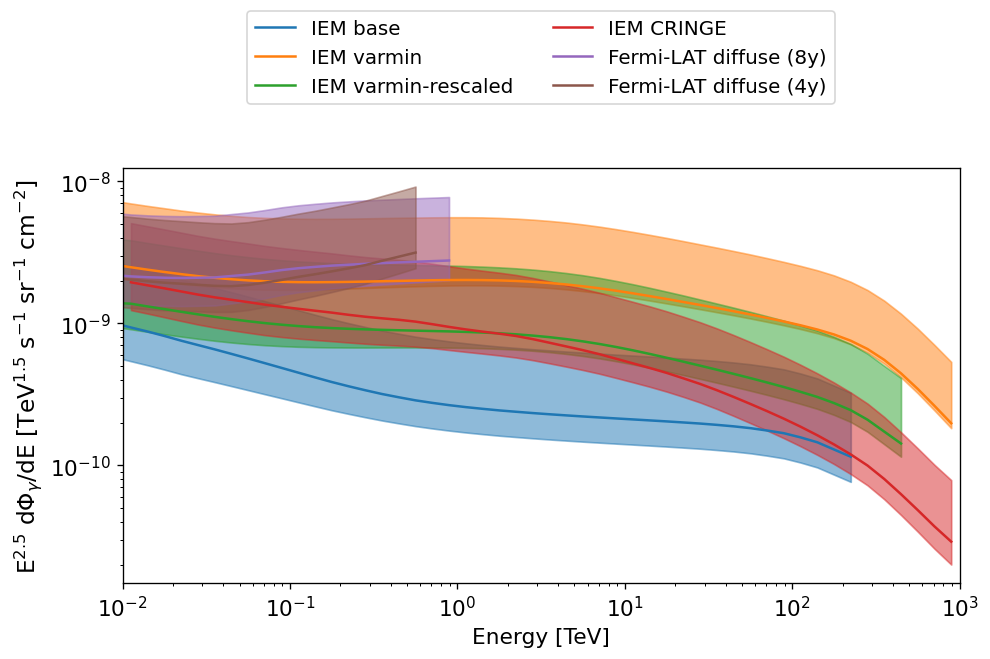

In [14]:
#IEM 

plt.figure(figsize=(9,4.5), dpi=120)
energy_power = 2.5
plt.xlim([1e-2, 1e3])
#plt.ylim([1.5e-11, 1.5e-9])
styles=["-","-","-","-","-","-","-","-"]
for color, ls, m, label in zip(defcol, styles, iem_base + iem_varmin+iem_varmin_rescaled+ iem_cringe+iem_fermi_v7+iem_fermi_v5,
                           ["IEM base","IEM varmin","IEM varmin-rescaled", "IEM CRINGE", "Fermi-LAT diffuse (8y)", "Fermi-LAT diffuse (4y)"]):
    if np.all(m.spectral_model.parameters.value == 1):
        continue
    m_dnde = Map.from_geom(fig_geom, data=m.evaluate_geom(fig_geom))
    #temapltes are 3d => spectrum change accros the map so we take the mean over the region 
    values = np.nanmean(m_dnde.quantity, axis=(1,2)).to("1/(TeV s sr cm2)")
    evalues = values*energies**energy_power

    # 26 and 84 percentiles will be used as edges to plot a band around the mean value
    values_16 = np.nanpercentile(m_dnde.quantity,16, axis=(1,2)).to("1/(TeV s sr cm2)")
    values_84 = np.nanpercentile(m_dnde.quantity,84 , axis=(1,2)).to("1/(TeV s sr cm2)")

    if  "Fermi-LAT" in label:
        values[energies>1*u.TeV]=0

    erange = energies[values>0]
    evalues = evalues[values>0]
    values_16 = values_16[values>0]
    values_84 = values_84[values>0]
    values = values[values>0]

    plt.loglog(erange, evalues, color=color, label=label, ls=ls)

    y_lo = (values - values_16)*erange**energy_power
    y_hi = (values + values_84)*erange**energy_power
    ax=plt.gca()
    ax.fill_between(erange.value, y_lo.value, y_hi.value, color=color, alpha=0.5)

plt.legend(ncol= 2, fontsize=11.9, loc='upper center', bbox_to_anchor=(0.5, 1.4))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Energy [TeV]", fontsize=13)
plt.ylabel(r'E$^{2.5}$ d$\Phi_{\gamma}$/dE [TeV$^{1.5}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$]', fontsize=14);

### Diffuse emission spectra measured by LHAASO

LHAASO measure diffuse emission outside of an exclusion mask :

In [15]:
#analysis mask used for LHAASO diffuse (https://arxiv.org/pdf/2305.05372)

lhaaso_diffuse_mask = Map.read(path+"maps/lhaaso/lhaaso_KM2A_official_pass5p2.fits")
print(lhaaso_diffuse_mask.geom)
                               

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (np.int64(4500), np.int64(500), 11)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 120.0 deg, 0.0 deg
	width      : 270.0 deg x 30.0 deg
	wcs ref    : 120.0 deg, 0.0 deg



<WCSAxes: >

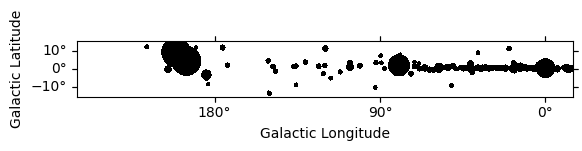

In [16]:
lhaaso_diffuse_mask.reduce_over_axes().plot()


Now let's create models matching the results given in the papers

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2 * dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

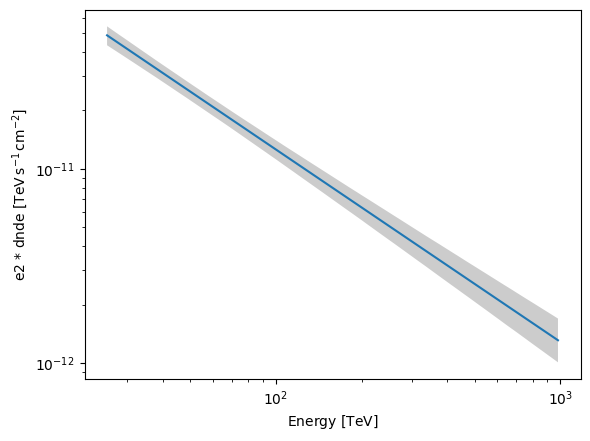

In [17]:
#KM2A: https://arxiv.org/pdf/2305.05372
lhaaso_km2a_diffuse = SkyModel(spatial_model=ConstantSpatialModel(value="1 sr−1"),
                          spectral_model=PowerLawSpectralModel(amplitude="1e-14 TeV−1 cm−2 s−1",
                                                index=2.99, reference=50*u.TeV)
                         )
lhaaso_km2a_diffuse.spectral_model.amplitude.error = 1e-14*np.sqrt(0.04**2+0.09**2)
lhaaso_km2a_diffuse.spectral_model.index.error = np.sqrt(0.04**2+0.07**2)

energy_bounds=[25, 1000]*u.TeV
lhaaso_km2a_diffuse.spectral_model.plot(energy_bounds, energy_power=2)
lhaaso_km2a_diffuse.spectral_model.plot_error(energy_bounds, energy_power=2)

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2 * dnde [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]'>

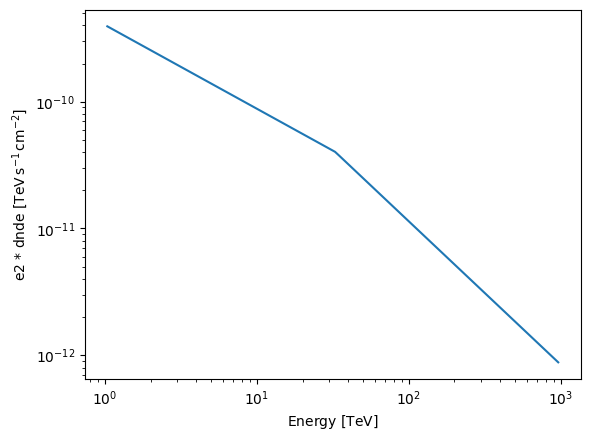

In [18]:
#WCDA: https://arxiv.org/pdf/2411.16021
pwl = PowerLawSpectralModel(amplitude="8.8e-13 TeV−1 cm−2 s−1",index=2.66, reference=10*u.TeV)
pwl.amplitude.error = 1e-13*0.53
pwl.index.error = 0.05
ebreak=32.84*u.TeV
amplitude, amplitude_errn, amplitude_errp = pwl.evaluate_error(ebreak)

lhaaso_diffuse = SkyModel(spatial_model=ConstantSpatialModel(value="1 sr−1"),
                          spectral_model= BrokenPowerLawSpectralModel(
                              amplitude=amplitude,
                              index1=2.66,
                              index2=3.13,
                              ebreak=ebreak,
                              #beta=0.01
                          )
                         )
lhaaso_diffuse.spectral_model.amplitude.error = amplitude_errp
lhaaso_diffuse.spectral_model.index1.error = 0.05
lhaaso_diffuse.spectral_model.index2.error = 0.08
#lhaaso_diffuse.spectral_model.ebreak.error = 11.16 

energy_bounds=[1, 1000]*u.TeV
lhaaso_diffuse.spectral_model.plot(energy_bounds, energy_power=2)
#lhaaso_diffuse.spectral_model.plot_error(energy_bounds, energy_power=2)

## 

Let's define a geomtry that match the analysis window of LHAASSO:

In [19]:
energy_axis =  MapAxis.from_energy_bounds(1e-3, 1000, 10, unit=u.TeV, per_decade=True, name="energy_true", node_type="edges")
fig_geom = WcsGeom.create(
                skydir=(70,0),
                binsz=0.1,
                width=(110, 10),
                frame="galactic",
                proj="CAR",
                axes=[energy_axis],
                )

energies = energy_axis.center.to("TeV")


and interpolate the mask toward this geom

<WCSAxes: >

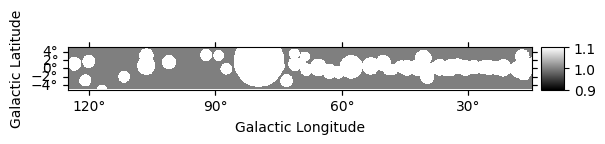

In [20]:
mask = lhaaso_diffuse_mask.reduce_over_axes().interp_to_geom(fig_geom.to_image(), method="nearest")
mask.data[mask!=0]=1
mask.data[mask==0]=np.nan
mask.plot(add_cbar=True, cmap="gray")

Here we precompute all the models and save them as template so we we can read them back faster 

In [21]:
geom_ref = iem_varmin_rescaled.spatial_model.map.geom.to_image().to_cube([energy_axis])

os.chdir(path+"models")
compute_sources = False
if compute_sources:
    cta_gps_source_models = cta_gps_models.copy()
    cta_gps_source_models.remove("GC ridge")
    cta_gps_source_models.remove("Fermi bubbles")
    cta_gps_source_models = cta_gps_source_models.to_template_sky_model(geom_ref)
    cta_gps_source_models.spatial_model.filename=path+"/models/sources/cta_gps_sources_template.fits.gz"
    cta_gps_source_models=Models(cta_gps_source_models)
    cta_gps_source_models.write(path+"/models/sources/cta_gps_source_template.yaml", overwrite=True)

    simulated_template = (iem_varmin_rescaled+cta_gps_source_models).to_template_sky_model(geom_ref)
    simulated_template.spatial_model.filename=path+"/models/sources/cta_gps_source_iem_varmin_rescaled_template.fits.gz"
    simulated_template = Models(simulated_template)
    simulated_template.write(path+"/models/sources/cta_gps_source_iem_varmin_rescaled_template.yaml", overwrite=True)

    simulated_template_cringe = (iem_cringe+cta_gps_source_models).to_template_sky_model(geom_ref)
    simulated_template_cringe.spatial_model.filename=path+"/models/sources/cta_gps_source_iem_cringe_template.fits.gz"
    simulated_template_cringe = Models(simulated_template_gringe)
    simulated_template_cringe.write(path+"/models/sources/cta_gps_source_iem_cringe_template.yaml", overwrite=True)
else:
    cta_gps_source_models = Models.read(path+"/models/sources/cta_gps_source_template.yaml")
    simulated_template = Models.read(path+"/models/sources/cta_gps_source_iem_varmin_rescaled_template.yaml")
    simulated_template_cringe = Models.read(path+"/models/sources/cta_gps_source_iem_cringe_template.yaml")


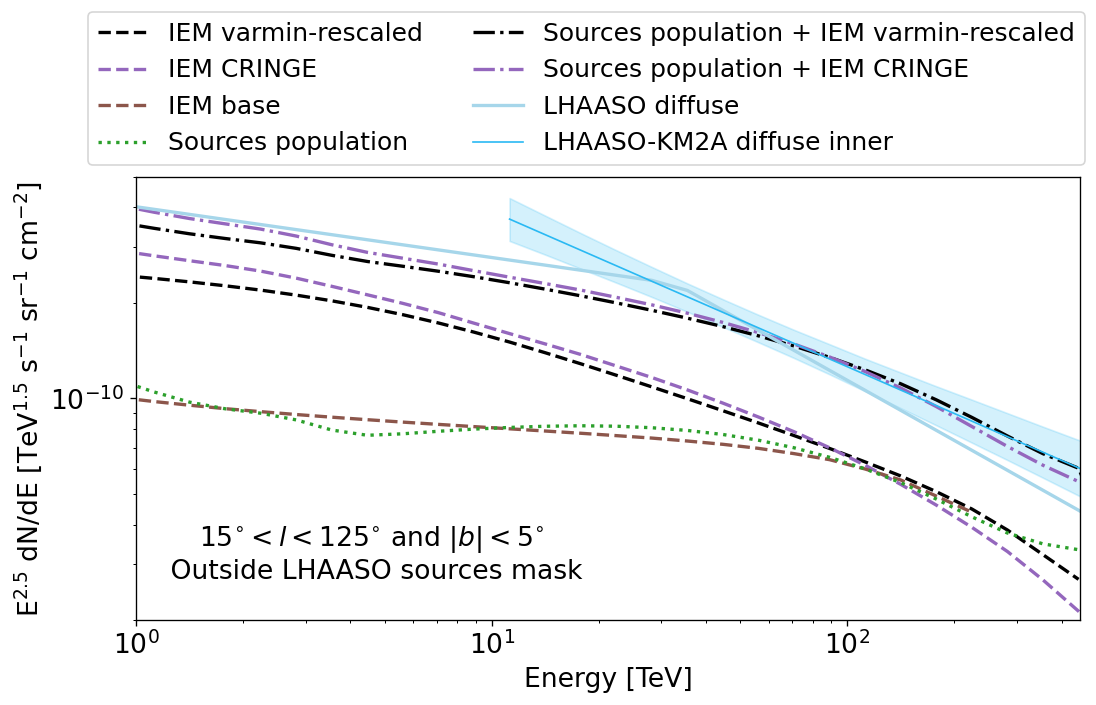

In [22]:
#IEM whitin LHAASO mask

plt.figure(figsize=(9.5,6.5), dpi=120)
energy_power = 2.5
plt.xlim([1, 4.5e2])
plt.ylim([2e-11, 5e-10])
styles=["--","--","--",":","-.","-.","-","-","-","-"]

 
ncolors = [
 "k",
 '#9467bd',
 '#8c564b',
 '#2ca02c',#'#d62728',
 "k",
 '#9467bd',
 #'#9467bd',
 #'#8c564b',
 '#A6D6EA',# '#e377c2',
 '#2AB9F3',#'#7f7f7f',
 '#bcbd22',
 '#17becf',
 'k']

for color, ls, m, label in zip(ncolors, styles, iem_varmin_rescaled+iem_cringe+ iem_base+cta_gps_source_models+simulated_template+simulated_template_cringe+lhaaso_diffuse+lhaaso_km2a_diffuse,
                           ["IEM varmin-rescaled","IEM CRINGE","IEM base","Sources population", "Sources population + IEM varmin-rescaled", "Sources population + IEM CRINGE ", "LHAASO diffuse", "LHAASO-KM2A diffuse inner"]):
    if np.all(m.spectral_model.parameters.value == 1):
        continue

    m_dnde = Map.from_geom(fig_geom, data=m.evaluate_geom(fig_geom))
    values = np.nanmean(m_dnde.quantity*mask.data[None,:,:], axis=(1,2)).to("1/(TeV s sr cm2)")
    evalues = values*energies**energy_power

    values_16 = np.nanpercentile(m_dnde.quantity*mask.data[None,:,:],16, axis=(1,2)).to("1/(TeV s sr cm2)")
    values_84 = np.nanpercentile(m_dnde.quantity*mask.data[None,:,:],84 , axis=(1,2)).to("1/(TeV s sr cm2)")
     
    if  "Fermi-LAT" in label:
        values[energies>1*u.TeV]=0

    if label == "LHAASO-KM2A diffuse inner":
        values[energies<10*u.TeV]=0

    erange = energies[values>0]
    evalues = evalues[values>0]
    values_16 = values_16[values>0]
    values_84 = values_84[values>0]
    values = values[values>0]

    if label != "LHAASO diffuse":
        norms, norms_errn, norms_errp = m.spectral_model.evaluate_error(erange)

    if np.all(norms_errn==0):
        plt.loglog(erange, evalues, color=color, label=label, ls=ls, lw=2)

        y_lo = (values_16)*erange**energy_power
        y_hi = (values_84)*erange**energy_power
        ax=plt.gca()
        #ax.fill_between(erange.value, y_lo.value, y_hi.value, color=color, alpha=0.2)
    else:
        plt.loglog(erange, evalues, color=color, label=label, ls=ls, lw=1)
        y_lo = (values - values*norms_errn/norms)*erange**energy_power
        y_hi = (values + values*norms_errp/norms)*erange**energy_power
        ax=plt.gca()
        ax.fill_between(erange.value, y_lo.value, y_hi.value, color=color, alpha=0.2)
#plt.title(r"$15^{\circ} < l < 125^{\circ}$ and $|b|<5^{\circ}$"+"\n Outside LHAASO known sources mask", fontsize=13,va="top",y=0.92, x=0.79)
plt.title(r"$15^{\circ} < l < 125^{\circ}$ and $|b|<5^{\circ}$"+"\n Outside LHAASO sources mask", fontsize=16,va="top",y=0.195, x=0.25)

plt.legend(ncol= 2, fontsize=15, loc='upper center', bbox_to_anchor=(0.477, 1.4))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Energy [TeV]", fontsize=16)
plt.ylabel(r'E$^{2.5}$ dN/dE [TeV$^{1.5}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$]', fontsize=16);
plt.tight_layout()

